In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import collections
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf

from tensorflow.keras import layers

from datetime import datetime

In [2]:
def get_longest_entry(unhandled_data):
    longest_sequence = 0
    sample_labels = list()

    for instance in unhandled_data:
        trace = instance["trace"]
        if longest_sequence < len(trace):
            longest_sequence = len(trace)

        label = instance["label"]
        if label not in sample_labels:
            sample_labels.append(label)

    sample_labels = np.array(sample_labels)

    print("Longest sequence length: {}".format(longest_sequence))
    print("Unique labels: {}".format(len(sample_labels)))

In [3]:
import json
from os import path

folder = "usable data style og"
filename = "cropped mouth.json"

print("Loading {}".format(filename))

raw_data = None
with open(path.join(folder, filename), "r") as json_data:
    raw_data = json.load(json_data)

instances = len(raw_data)

labels = list()
for instance in raw_data:
    label = instance["label"]
    if label not in labels:
        labels.append(label)

print("Loaded {} instances".format(instances))
print("Loaded {} labels".format(len(labels)))

Loading cropped mouth.json
Loaded 4305 instances
Loaded 5 labels


In [4]:
from tabulate import tabulate

top_limit = 5

word_hits = dict()

for instance in raw_data:
    label = instance["label"]
    
    if label not in word_hits:
        word_hits[label] = 0
        
    word_hits[label] += 1

sorted_sizes = sorted([(size, word) for word, size in word_hits.items()], reverse=True)

top_words = sorted_sizes[:top_limit]

sizes = [pair[0] for pair in top_words]
words = [pair[1] for pair in top_words]

shares = ["{} %".format(round(100/sum(sizes)*size, 1)) for size in sizes]

print("Top {} words".format(top_limit))
print(tabulate({
    "Word": words,
    "Size": sizes,
    "Share": shares
}, headers="keys"))

# Transfer these to a new dataset
top_data = list()

for instance in raw_data:
    label = instance["label"]
    
    if label in words:
        top_data.append(instance)

Top 5 words
Word      Size  Share
------  ------  -------
the       1034  24.0 %
you        882  20.5 %
a          844  19.6 %
and        781  18.1 %
to         764  17.7 %


In [5]:
longest_sequence = 0
sample_labels = list()

for instance in top_data:
    trace = instance["mouth"]
    if longest_sequence < len(trace):
        longest_sequence = len(trace)

    label = instance["label"]
    if label not in sample_labels:
        sample_labels.append(label)

sample_labels = np.array(sample_labels)
        
print("Longest sequence length: {}".format(longest_sequence))
print("Unique labels: {}".format(len(sample_labels)))

Longest sequence length: 340
Unique labels: 5


In [6]:
frame_lengths = dict()

for instance in top_data:
    length = len(instance["mouth"])
    
    if length not in frame_lengths:
        frame_lengths[length] = 0
        
    frame_lengths[length] += 1
    
sorted_lengths = sorted((key, value) for key, value in frame_lengths.items())

In [7]:
required_hits = 20

slicer = 0
instances_being_dropped = 0

new_max = 0

for counter, pair in enumerate(sorted_lengths[::-1]):
    length, hits = pair
    
    if hits >= required_hits:
        slicer = counter
        new_max = length
        break
    
    instances_being_dropped += hits
    
dropping = sorted_lengths[-slicer:]
keeping = sorted_lengths[:-slicer]

print("DROPPING")
print(" lengths: {lengths}\n instances: {instances}".format(
    lengths=len(dropping),
    instances=sum(hits for length, hits in dropping) 
), end="\n\n")
    
print("KEEPING")
print(" lengths: {lengths}\n instances: {instances}".format(
    lengths=len(keeping),
    instances=sum(hits for length, hits in keeping) 
), end="\n\n")

print("Dropping {}% instances".format(round(100/instances*instances_being_dropped, 2)))
print("Complexity reduced from {} to {} ({}%)".format(
    longest_sequence, length, round(100/longest_sequence*new_max, 2) 
))

DROPPING
 lengths: 22
 instances: 53

KEEPING
 lengths: 18
 instances: 4252

Dropping 1.23% instances
Complexity reduced from 340 to 54 (15.88%)


In [8]:
data = top_data.copy()

dropped = 0

for entry in top_data:
    label = entry["label"]
    trace = np.array(entry["mouth"])
    
    if len(trace) > new_max:
        data.remove(entry)
        dropped += 1

print("Dropped {}\nInstances:\n Before: {}\n After: {}".format(
    dropped,
    len(top_data),
    len(data),
))

Dropped 53
Instances:
 Before: 4305
 After: 4252


In [9]:
label_counter = dict()
for instance in data:
    label = instance["label"]
    
    if label not in label_counter:
        label_counter[label] = 0
    label_counter[label] += 1

sorted_sizes = sorted([(size, word) for word, size in label_counter.items()], reverse=True)

top_words = sorted_sizes[:top_limit]

sizes = [pair[0] for pair in top_words]
words = [pair[1] for pair in top_words]

print("### BEFORE ###")
print("Top {} words".format(top_limit))
print(tabulate({
    "Word": words,
    "Size": sizes,
}, headers="keys"))

max_size = sizes[-1]

label_counter = dict()

sample = list()

for instance in data:
    label = instance["label"]
    
    if label not in label_counter:
        label_counter[label] = 0
    label_counter[label] += 1
    
    # If there is still room for it, append it
    if label_counter[label] <= max_size:
        sample.append(instance)
        
label_counter = dict()
for instance in sample:
    label = instance["label"]
    
    if label not in label_counter:
        label_counter[label] = 0
    label_counter[label] += 1

sorted_sizes = sorted([(size, word) for word, size in label_counter.items()], reverse=True)

top_words = sorted_sizes[:top_limit]

sizes = [pair[0] for pair in top_words]
words = [pair[1] for pair in top_words]

print("\n### AFTER ###")
print("Top {} words".format(top_limit))
print(tabulate({
    "Word": words,
    "Size": sizes,
}, headers="keys"))

### BEFORE ###
Top 5 words
Word      Size
------  ------
the       1024
you        873
a          837
and        761
to         757

### AFTER ###
Top 5 words
Word      Size
------  ------
you        757
to         757
the        757
and        757
a          757


In [10]:
longest_sequence = 0
sample_labels = list()

for instance in sample:
    trace = instance["mouth"]
    if longest_sequence < len(trace):
        longest_sequence = len(trace)

    label = instance["label"]
    if label not in sample_labels:
        sample_labels.append(label)

sample_labels = np.array(sample_labels)

print("Longest sequence length: {}".format(longest_sequence))
print("Unique labels: {}".format(len(sample_labels)))

Longest sequence length: 54
Unique labels: 5


In [11]:
import ipywidgets as widgets
output = widgets.Output()
output

Output()

In [12]:
print("Processing... (Look above for progress)")
time_start = datetime.utcnow()
size = len(sample)

y = list()
X = list()

for iii, instance in enumerate(sample):
    label = instance["label"]
    trace = list()
    for frame in instance["mouth"]:
        # trace.append(np.array(frame).reshape(25, 30))
        # trace.append(np.reshape(np.array(frame), (25, 30)))
        trace.append(np.array(frame))
        
    trace = np.array(trace)
    new_entry = np.zeros((longest_sequence, 750))
    
    new_entry[-len(trace):] = trace
    
    """
    for frame_index, frame in enumerate(trace):
        new_entry[-len(trace)+frame_index] = frame
    """
    
    # The data does now have the sequences in the rows, tensorflow expects the time series to be in the rows
    # Transpose the data so that this becomes the case
    # new_entry = new_entry.T
    
    # Append both the training data and the label
    X.append(new_entry)
    y.append(label)
    
    with output:
        output.clear_output(wait=True)
        time_elapsed = datetime.utcnow() - time_start
        
        print("{} / {}".format(iii+1, size))
        print("{}%".format(round(100/size*(iii+1), 1)))
        print("Time elapsed: {minutes}m {seconds}s".format(
            minutes=time_elapsed.seconds//60,
            seconds=time_elapsed.seconds%60
        ))

# Convert the final result to numpy array
# Even though the sequences vary in length, they have been padded and are now all the same length
# This allows the conversion to numpy array
X = np.array(X)

# Normalize the entire data
X /= X.max()
    
print("Prepared {} data points".format(len(X)))
print("Data shape: {}".format(X.shape))

Processing... (Look above for progress)


In [13]:
from pandas import Series, factorize

list_with_duplicates = ["a", "b", "c", "c", "b"]
series_test = Series(list_with_duplicates)

sample_labels_test, levels_test = factorize(series_test)

print(list_with_duplicates)
print(sample_labels_test)

series = Series(y)

original_y = y.copy()

print(original_y[:10])

y, levels = factorize(series)

print(y[:10])

['a', 'b', 'c', 'c', 'b']
[0 1 2 2 1]
['a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a']
[0 0 0 0 0 0 0 0 0 0]


In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

print("Training: {} Shape: {}".format(len(X_train), X_train.shape))
print("Testing: {} Shape: {}".format(len(X_test), X_test.shape))

Training: 3028 Shape: (3028, 54, 750)
Testing: 757 Shape: (757, 54, 750)


In [15]:
# The length of the series can change, so check what the shape is for the training data and use that
# The height will be number 
sequence_length = X_train.shape[1]
time_series = X_train.shape[2]

input_dim = (sequence_length, time_series)

print(input_dim)

# Each MNIST image batch is a tensor of shape (batch_size, 28, 28).
# Each input sequence will be of size (28, 28) (height is treated like time).
# input_dim = (longest_sequence, 40)

units = 64
output_size = len(sample_labels)  # labels are from 0 to 9

print("Input: {}".format(input_dim))
print("Output: {}".format(output_size))

# Build the RNN model
def build_model(allow_cudnn_kernel=True):
    
    # CuDNN is only available at the layer level, and not at the cell level.
    # This means `LSTM(units)` will use the CuDNN kernel,
    # while RNN(LSTMCell(units)) will run on non-CuDNN kernel.
    if allow_cudnn_kernel:
        print(input_dim)
        
        # The LSTM layer with default options uses CuDNN.
        lstm_layer = tf.keras.layers.LSTM(units, input_shape=input_dim)
        
    else:
        # Wrapping a LSTMCell in a RNN layer will not use CuDNN.
        lstm_layer = tf.keras.layers.RNN(
            tf.keras.layers.LSTMCell(units), input_shape=input_dim
        )
        
    model = tf.keras.models.Sequential([
        lstm_layer,
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(output_size)
    ])
    
    return model

(54, 750)
Input: (54, 750)
Output: 5


In [16]:
"""
import keras

# The length of the series can change, so check what the shape is for the training data and use that
# The height will be number 
sequence_length = X_train.shape[1]
frame_height = X_train.shape[2]
frame_width = X_train.shape[3]

input_dim = (sequence_length, frame_height, frame_width)

print(input_dim)

# Each MNIST image batch is a tensor of shape (batch_size, 28, 28).
# Each input sequence will be of size (28, 28) (height is treated like time).
# input_dim = (longest_sequence, 40)

units = 64
output_size = len(sample_labels)  # labels are from 0 to 9

print("Input: {}".format(input_dim))
print("Output: {}".format(output_size))

# Build the RNN model
def build_model(allow_cudnn_kernel=True):
    
    # CuDNN is only available at the layer level, and not at the cell level.
    # This means `LSTM(units)` will use the CuDNN kernel,
    # while RNN(LSTMCell(units)) will run on non-CuDNN kernel.
    if allow_cudnn_kernel:
        print(input_dim)
        
        # The LSTM layer with default options uses CuDNN.
        lstm_layer = tf.keras.layers.LSTM(units, input_shape=input_dim)
        
    else:
        # Wrapping a LSTMCell in a RNN layer will not use CuDNN.
        lstm_layer = tf.keras.layers.RNN(
            tf.keras.layers.LSTMCell(units), input_shape=input_dim
        )
    model = tf.keras.models.Sequential()
    model.add(keras.layers.Lambda(lambda x: tf.expand_dims(model.output, axis=-1)))

    model.add(lstm_layer)
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dense(output_size))
    model = tf.keras.models.Sequential()
    model = tf.expand_dims(model, axis=-1)(model)
    model.add(lstm_layer)
    model.add(tf.keras.layers.BatchNormalization())
    # model.add(lstm_layer)
    model = tf.keras.layers.Dense(output_size)(model)
        
    model = tf.keras.models.Sequential([
        lstm_layer,
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(output_size)
    ])
    
    input_layer = Input((30,24,48))

    model = Conv2D(20,(5,5), input_shape = (30,24,48), activation = "relu", strides = 1, padding = "valid")(input_layer)
    model = MaxPooling2D(pool_size=(2,2))(model)        
    model = Conv2D(50, (5,5), use_bias = 50)(model)    
    model = MaxPooling2D(pool_size=(2,2))(model)  
    model = Flatten()(model)
    model = Dense(20, activation = "relu")(model)
    model = tf.expand_dims(model, axis=-1)
    model = LSTM(50, activation="relu", return_sequences=True)(model)
    
    return model
"""
    

'\nimport keras\n\n# The length of the series can change, so check what the shape is for the training data and use that\n# The height will be number \nsequence_length = X_train.shape[1]\nframe_height = X_train.shape[2]\nframe_width = X_train.shape[3]\n\ninput_dim = (sequence_length, frame_height, frame_width)\n\nprint(input_dim)\n\n# Each MNIST image batch is a tensor of shape (batch_size, 28, 28).\n# Each input sequence will be of size (28, 28) (height is treated like time).\n# input_dim = (longest_sequence, 40)\n\nunits = 64\noutput_size = len(sample_labels)  # labels are from 0 to 9\n\nprint("Input: {}".format(input_dim))\nprint("Output: {}".format(output_size))\n\n# Build the RNN model\ndef build_model(allow_cudnn_kernel=True):\n    \n    # CuDNN is only available at the layer level, and not at the cell level.\n    # This means `LSTM(units)` will use the CuDNN kernel,\n    # while RNN(LSTMCell(units)) will run on non-CuDNN kernel.\n    if allow_cudnn_kernel:\n        print(input_di

In [17]:
model = build_model()

(54, 750)


In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 64)                208640    
_________________________________________________________________
batch_normalization (BatchNo (None, 64)                256       
_________________________________________________________________
dense (Dense)                (None, 5)                 325       
Total params: 209,221
Trainable params: 209,093
Non-trainable params: 128
_________________________________________________________________


In [19]:
model = build_model(allow_cudnn_kernel=True)

model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer='sgd',
    metrics=['accuracy']
)

(54, 750)


In [20]:
history = model.fit(
    X_train, y_train, 
    validation_data=(X_test, y_test),
    # batch_size=batch_size,
    epochs=200)

Train on 3028 samples, validate on 757 samples
Epoch 1/200
3028/3028 [==============================] - 4s 1ms/sample - loss: 1.6493 - accuracy: 0.3147 - val_loss: 1.5880 - val_accuracy: 0.2431
Epoch 2/200
3028/3028 [==============================] - 2s 744us/sample - loss: 1.5206 - accuracy: 0.3468 - val_loss: 1.5573 - val_accuracy: 0.2880
Epoch 3/200
3028/3028 [==============================] - 2s 755us/sample - loss: 1.4663 - accuracy: 0.3745 - val_loss: 1.5608 - val_accuracy: 0.2576
Epoch 4/200
3028/3028 [==============================] - 2s 769us/sample - loss: 1.4331 - accuracy: 0.3937 - val_loss: 1.5609 - val_accuracy: 0.3342
Epoch 5/200
3028/3028 [==============================] - 2s 770us/sample - loss: 1.4037 - accuracy: 0.4042 - val_loss: 1.6608 - val_accuracy: 0.2787
Epoch 6/200
3028/3028 [==============================] - 2s 763us/sample - loss: 1.3926 - accuracy: 0.4194 - val_loss: 1.5381 - val_accuracy: 0.3672
Epoch 7/200
3028/3028 [==============================] - 2s 7

3028/3028 [==============================] - 2s 816us/sample - loss: 0.8815 - accuracy: 0.6651 - val_loss: 2.1448 - val_accuracy: 0.3170
Epoch 56/200
3028/3028 [==============================] - 2s 812us/sample - loss: 0.8763 - accuracy: 0.6598 - val_loss: 2.7512 - val_accuracy: 0.2946
Epoch 57/200
3028/3028 [==============================] - 3s 872us/sample - loss: 0.8680 - accuracy: 0.6608 - val_loss: 2.4652 - val_accuracy: 0.3144
Epoch 58/200
3028/3028 [==============================] - 2s 814us/sample - loss: 0.8628 - accuracy: 0.6674 - val_loss: 2.8780 - val_accuracy: 0.2642
Epoch 59/200
3028/3028 [==============================] - 3s 851us/sample - loss: 0.8629 - accuracy: 0.6747 - val_loss: 2.4137 - val_accuracy: 0.2840
Epoch 60/200
3028/3028 [==============================] - 3s 827us/sample - loss: 0.8407 - accuracy: 0.6787 - val_loss: 3.5040 - val_accuracy: 0.2933
Epoch 61/200
3028/3028 [==============================] - 2s 820us/sample - loss: 0.8295 - accuracy: 0.6816 - val

3028/3028 [==============================] - 3s 827us/sample - loss: 0.4439 - accuracy: 0.8451 - val_loss: 3.7611 - val_accuracy: 0.2563
Epoch 110/200
3028/3028 [==============================] - 3s 838us/sample - loss: 0.4605 - accuracy: 0.8260 - val_loss: 4.5158 - val_accuracy: 0.2721
Epoch 111/200
3028/3028 [==============================] - 3s 835us/sample - loss: 0.4496 - accuracy: 0.8369 - val_loss: 3.2766 - val_accuracy: 0.2840
Epoch 112/200
3028/3028 [==============================] - 3s 834us/sample - loss: 0.4168 - accuracy: 0.8481 - val_loss: 3.1031 - val_accuracy: 0.3144
Epoch 113/200
3028/3028 [==============================] - 3s 832us/sample - loss: 0.4275 - accuracy: 0.8504 - val_loss: 4.4797 - val_accuracy: 0.2972
Epoch 114/200
3028/3028 [==============================] - 3s 850us/sample - loss: 0.4577 - accuracy: 0.8326 - val_loss: 4.8812 - val_accuracy: 0.2061
Epoch 115/200
3028/3028 [==============================] - 3s 842us/sample - loss: 0.3811 - accuracy: 0.8643

3028/3028 [==============================] - 2s 818us/sample - loss: 0.2250 - accuracy: 0.9254 - val_loss: 5.9430 - val_accuracy: 0.2523
Epoch 164/200
3028/3028 [==============================] - 2s 815us/sample - loss: 0.1976 - accuracy: 0.9363 - val_loss: 4.8130 - val_accuracy: 0.2787
Epoch 165/200
3028/3028 [==============================] - 2s 819us/sample - loss: 0.1784 - accuracy: 0.9435 - val_loss: 4.8985 - val_accuracy: 0.2761
Epoch 166/200
3028/3028 [==============================] - 3s 840us/sample - loss: 0.1757 - accuracy: 0.9491 - val_loss: 4.1891 - val_accuracy: 0.3038
Epoch 167/200
3028/3028 [==============================] - 3s 829us/sample - loss: 0.2042 - accuracy: 0.9343 - val_loss: 4.9671 - val_accuracy: 0.2325
Epoch 168/200
3028/3028 [==============================] - 2s 822us/sample - loss: 0.2327 - accuracy: 0.9145 - val_loss: 6.0822 - val_accuracy: 0.2668
Epoch 169/200
3028/3028 [==============================] - 3s 828us/sample - loss: 0.2079 - accuracy: 0.9273

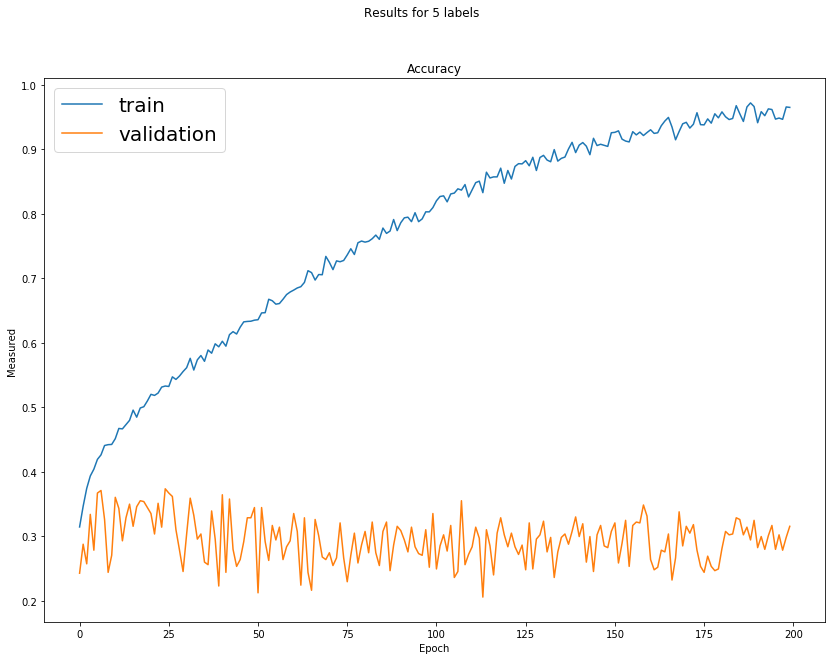

In [21]:
fig, axis = plt.subplots(1, 1, figsize=(14, 10))

acc = np.array(history.history['accuracy'])
val_acc = np.array(history.history['val_accuracy'])

axis.plot(acc, label="train")
axis.plot(val_acc, label="validation")

axis.set_title("Accuracy")

axis.set_ylabel("Measured")
axis.set_xlabel("Epoch")
plt.suptitle("Results for {} labels".format(output_size))

plt.legend(prop={'size': 20})
plt.show()

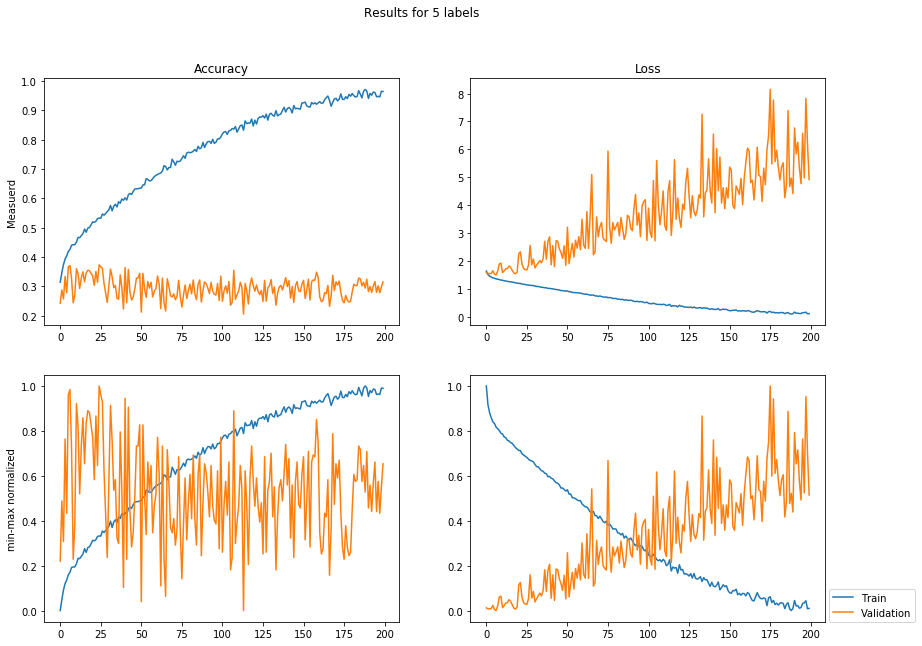

In [22]:
fig, axis = plt.subplots(2, 2, figsize=(14, 10))

loss = np.array(history.history['loss'])
val_loss = np.array(history.history['val_loss'])
acc = np.array(history.history['accuracy'])
val_acc = np.array(history.history['val_accuracy'])

loss_min, loss_max = loss.min(), loss.max()
acc_min, acc_max = acc.min(), acc.max()
val_loss_min, val_loss_max = val_loss.min(), val_loss.max()
val_acc_min, val_acc_max = val_acc.min(), val_acc.max()

loss_n = (loss-loss_min)/(loss_max-loss_min)
acc_n = (acc-acc_min)/(acc_max-acc_min)
val_loss_n = (val_loss-val_loss_min)/(val_loss_max-val_loss_min)
val_acc_n = (val_acc-val_acc_min)/(val_acc_max-val_acc_min)

# val_loss_n = val_loss/val_loss.max()
# val_accuracy_n = val_accuracy/val_accuracy.max()

axis[0][0].plot(acc)
axis[0][0].plot(val_acc)

axis[0][1].plot(loss)
axis[0][1].plot(val_loss)

axis[1][0].plot(acc_n)
axis[1][0].plot(val_acc_n)

axis[1][1].plot(loss_n, label="Train")
axis[1][1].plot(val_loss_n, label="Validation")

axis[1][1].legend(loc=(1.01, 0))

axis[0][0].set_title("Accuracy")
axis[0][1].set_title("Loss")

axis[0][0].set_ylabel("Measuerd")
axis[1][0].set_ylabel("min-max normalized")
plt.suptitle("Results for {} labels".format(output_size))

plt.show()

In [23]:
data_overview = da.training_data_overview()

rected_videos = list()

for video in data_overview:
    if "TEST" in video:
        continue
    
    mean_confidences = dict()
    
    is_rected = Transcriber(video, quick=True).is_rected()
    
    for speed in data_overview[video]:
        
        try:
            t = Transcriber(video, speed, quick=True)
            mean_confidences[speed] = round(t.mean_confidence(), 3)
        except:
            pass
    
    sorted_means = sorted([(confidence, int(speed)) for speed, confidence in mean_confidences.items()], reverse=True)
    sorted_means = [means[::-1] for means in sorted_means]
    
    if sorted_means:
        if not is_rected:
            print(end="NOT RECTED ############### ")
        else:
            rected_videos.append(video)
        print(video)
        print(*sorted_means)
        print()

NameError: name 'da' is not defined

In [ ]:
rected_videos

In [ ]:
best_transcripts = dict()

highest_confidence = 0
slowest_transcription = 1

best_criteria = slowest_transcription

for video in data_overview:
    
    # Create a transcriber object without transcribing capabilities, only use it to handle this video
    t = Transcriber(video, quick=True)
    
    # Skip if it is not rected
    if not t.is_rected() or "TEST" in t.get_folder():
        continue
    
    if best_criteria == slowest_transcription:
        
        speeds = list()

        for speed in data_overview[video]:
            t.set_speed(speed)

            speeds.append([
                int(speed),
                round(t.mean_confidence(), 4)
            ])

        speeds.sort()
        
        speeds = [pair[::-1] for pair in speeds]

        best_transcripts[video] = speeds[0]
        
    elif best_criteria == highest_confidence:
        mean_confidences = list()

        for speed in data_overview[video]:
            t.set_speed(speed)

            mean_confidences.append([
                round(t.mean_confidence(), 4),
                speed
            ])

        mean_confidences.sort(reverse=True)

        best_transcripts[video] = mean_confidences[0]

In [ ]:
from tabulate import tabulate

videos = list()
confidences = list()
speeds = list()

for video in best_transcripts:
    videos.append(video)
    
    confidence, speed = best_transcripts[video]
    
    confidences.append(confidence)
    speeds.append(speed)
    
print(tabulate({
    "Video, {} total".format(len(videos)): videos,
    "Confidence": confidences,
    "Speed": speeds
}, headers="keys"))

In [ ]:
data = dict()

for iii, video in enumerate(best_transcripts):
    print(video)
    print("Video {}/{}... ".format(iii+1, len(best_transcripts)), end="")
    
    confidence = best_transcripts[video][0]
    speed = best_transcripts[video][1]
    t = Transcriber(video, speed, quick=True)
    
    action = "Read"
    
    if not t.usable_words_determined():
        t.determine_usable_words()
        action = "Extracted"
        
    words = t.get_usable_words()
    
    print("{action} {wordcount} words, {total} total.".format(
        action=action,
        wordcount=len(words),
        total=sum(len(words[word]) for word in words)
    ), end="\n\n")
    
    for word in words:
    
        if word not in data:
            data[word] = list()
            
        data[word].extend(words[word])

In [ ]:
wordcount = len(data)
total_words = sum(len(data[word]) for word in data)

print("Wordcount: {}".format(wordcount))
print("Total words: {}".format(total_words))

In [ ]:
import json

def create_grouped():
    print("Creating grouped")
    output_filename = path.join("sequence classification style og", "data_grouped_slowest.json")
    print("Writing")

    # Dump the dictionary to a json file
    with open(output_filename, "w") as json_file:
        json.dump(data, json_file, indent=2)
    print("Done")
        
def create_sorted():
    print("Creating sorted")
    output_filename = path.join("sequence classification style og", "data_sorted_slowest.json")
    
    # List over the dictionaries that hold words
    data_to_write = list()
    
    # Iterate each word and each instance of that word and copy to the list as they appear
    sorted_words = sorted(word for word in data)
    
    print("Sorting")
    for word in sorted_words:
        
        for instance in data[word]:
            
            data_to_write.append({
                "label": word,
                "trace": instance
            })
            
    print("Writing")
    # Dump the dictionary to a json file
    with open(output_filename, "w") as json_file:
        json.dump(data_to_write, json_file, indent=2)
    
    print("Done")

def create_shuffled():
    output_filename = path.join("sequence classification style og", "data_dispersed.json")
    
    # List over the dictionaries that hold words
    data_to_write = list()
    
    # Loop through the data and select a random word to extract from
    # Remove this first 
    while data:
        
        word = random.choice([word for word in data])
        
        instance = random.choice([])

In [ ]:
create_sorted()
create_grouped()

In [ ]:
# Deletes every single usable_words.json file it can find
def purge_usable_words():
    deletes = 0
    
    data_overview = da.training_data_overview()

    for video in data_overview:

        mean_confidences = dict()

        is_rected = Transcriber(video, quick=True).is_rected()
        
        if not is_rected:
            continue

        for speed in data_overview[video]:

            t = Transcriber(video, speed, quick=True)

            folder = path.join(t.get_speed_folder())

            filename = path.join(folder, t.usable_words_name)

            if path.isfile(filename):
                os.remove(filename)
                deletes += 1
                
    return deletes

In [ ]:
# print(purge_usable_words())